Epoch 1/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.3957 - loss: 1.3880 - val_accuracy: 0.6181 - val_loss: 0.9327
Epoch 2/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.5578 - loss: 1.0122 - val_accuracy: 0.6761 - val_loss: 0.8493
Epoch 3/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - accuracy: 0.6491 - loss: 0.8618 - val_accuracy: 0.7188 - val_loss: 0.7172
Epoch 4/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.7016 - loss: 0.7571 - val_accuracy: 0.7113 - val_loss: 0.7147
Epoch 5/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - accuracy: 0.7311 - loss: 0.6880 - val_accuracy: 0.7584 - val_loss: 0.6180
Epoch 6/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.7619 - loss: 0.6176 - val_accuracy: 0.7372 - val_loss: 0.6827
Epoch 7/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.7813 - loss: 0.5666 - val_accuracy: 0.7628 - val_loss: 0.6183
Epoch 8/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - accuracy: 0.7914 - loss: 0.5391 - 

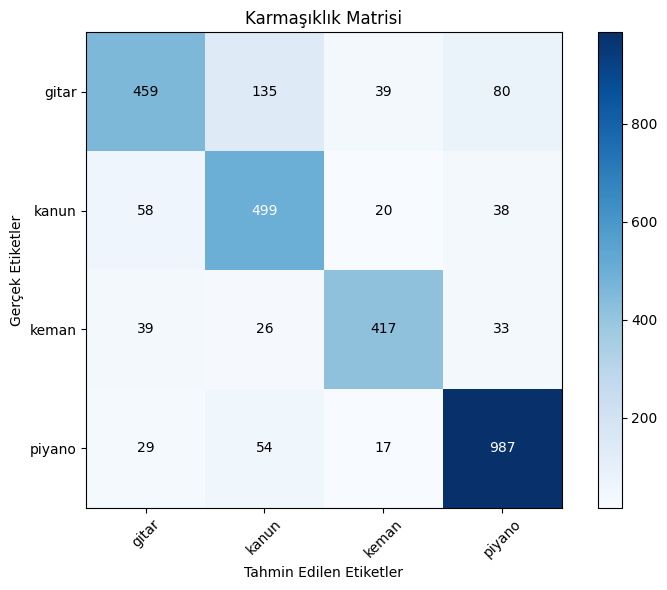

Karmaşıklık Matrisi:
[[459 135  39  80]
 [ 58 499  20  38]
 [ 39  26 417  33]
 [ 29  54  17 987]]


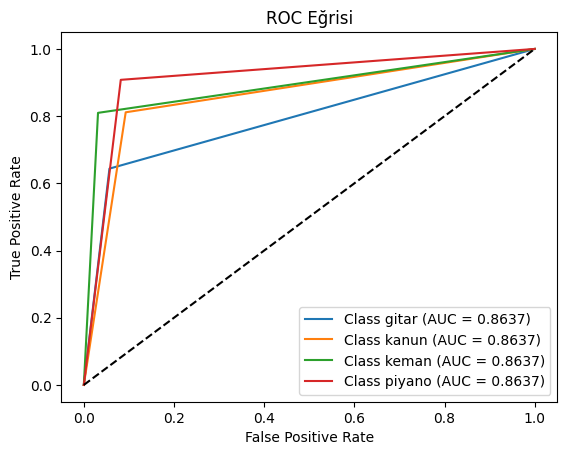

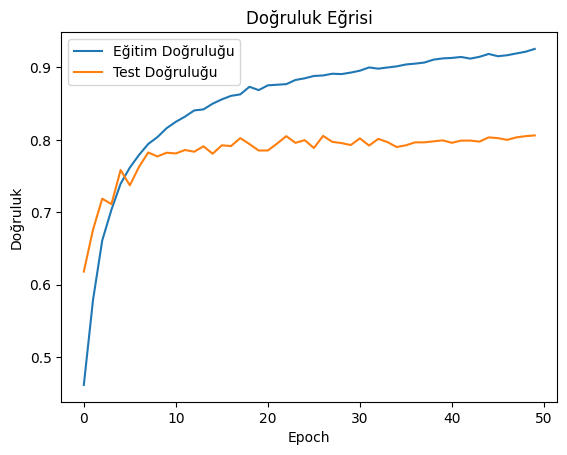

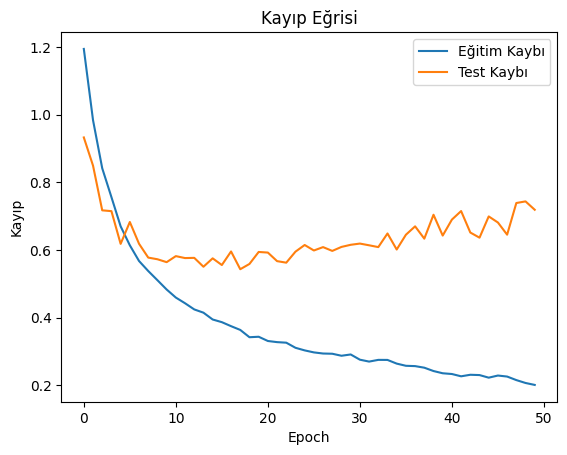

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step 
Çıkarım süresi: 0.9134 saniye
Eğitim süresi: 1015.9630 saniye


In [8]:
 import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LayerNormalization, MultiHeadAttention, Dense, Dropout, Flatten
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import time

# Veriyi hazırlama
mfcc_data = []
labels = []

# Klasör isimleri ve etiketler
enstruman_klasorleri = {
    "mfcc_cikti_gitar": "gitar",
    "mfcc_cikti_kanun": "kanun",
    "mfcc_cikti_keman": "keman",
    "mfcc_cikti_piyano": "piyano"
}

# Ana dizinin yolu
ana_dizin = r"C:\Users\Buse Yener\makineProje"

# Maksimum kare sayısını belirleme
TARGET_SHAPE = (100, 13)  # 100 zaman adımı, 13 MFCC katsayısı

# Her klasör için
for klasor, etiket in enstruman_klasorleri.items():
    klasor_yolu = os.path.join(ana_dizin, klasor)
    
    # Klasördeki her npy dosyasını yükleme
    for dosya_adi in os.listdir(klasor_yolu):
        if dosya_adi.endswith(".npy"):
            dosya_yolu = os.path.join(klasor_yolu, dosya_adi)
            mfcc = np.load(dosya_yolu)
            
            # MFCC verisini hedef boyuta getirme
            if mfcc.shape[1] > TARGET_SHAPE[1]:  # Çok fazla sütun varsa kes
                mfcc = mfcc[:, :TARGET_SHAPE[1]]
            elif mfcc.shape[1] < TARGET_SHAPE[1]:  # Eksik sütun varsa sıfır doldur
                padding_columns = np.zeros((mfcc.shape[0], TARGET_SHAPE[1] - mfcc.shape[1]))
                mfcc = np.hstack((mfcc, padding_columns))

            # Boyut eşitleme (satır bazında)
            if mfcc.shape[0] > TARGET_SHAPE[0]:  # Çok uzun ise kes
                mfcc = mfcc[:TARGET_SHAPE[0], :]
            elif mfcc.shape[0] < TARGET_SHAPE[0]:  # Çok kısa ise sıfır doldur
                padding_rows = np.zeros((TARGET_SHAPE[0] - mfcc.shape[0], TARGET_SHAPE[1]))
                mfcc = np.vstack((mfcc, padding_rows))
            
            # Veriyi ve etiketi listelere ekleme
            mfcc_data.append(mfcc.flatten())  # Düzleştirilmiş hale getirildi
            labels.append(etiket)

# Eğitim için kullanılacak veri ve etiketler
mfcc_data = np.array(mfcc_data)
labels = np.array(labels)

# Etiketleri sayısal kodlama
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Veri setini eğitim ve test olarak ayırma
X_train, X_test, y_train, y_test = train_test_split(mfcc_data, encoded_labels, test_size=0.2, random_state=42)

# SMOTE ile veri dengesizliğini giderme
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Data2Vec için veri şekillendirme
X_train_smote = X_train_smote.reshape((X_train_smote.shape[0], TARGET_SHAPE[0], TARGET_SHAPE[1]))
X_test = X_test.reshape((X_test.shape[0], TARGET_SHAPE[0], TARGET_SHAPE[1]))

# Data2Vec Modeli
def data2vec(inputs, num_heads=4, key_dim=64, ff_dim=256, dropout_rate=0.1):
    # Multi-Head Attention layer
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(inputs, inputs)
    attention_output = LayerNormalization()(attention_output)
    
    # Feed Forward Network
    ff_output = Dense(ff_dim, activation='relu')(attention_output)
    ff_output = Dropout(dropout_rate)(ff_output)
    ff_output = Dense(inputs.shape[-1])(ff_output)
    
    # Layer normalization and residual connection
    output = LayerNormalization()(inputs + ff_output)
    
    return output

# Model
input_layer = Input(shape=(TARGET_SHAPE[0], TARGET_SHAPE[1]))

# Data2Vec 
x = data2vec(input_layer)

# Flatten the output and apply Dense layers
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

# Output layer
output_layer = Dense(4, activation='softmax')(x)

# Modeli oluşturma
model = Model(inputs=input_layer, outputs=output_layer)

# Modeli derleme
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Modeli eğitme
start_time = time.time()
history = model.fit(X_train_smote, y_train_smote, epochs=50, batch_size=32, validation_data=(X_test, y_test))
training_time = time.time() - start_time

# Modeli değerlendirme
y_pred = np.argmax(model.predict(X_test), axis=1)

# Performans metriklerini hesaplama
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
auc = roc_auc_score(y_test, tf.keras.utils.to_categorical(y_pred, num_classes=4), multi_class='ovr')

# Karmaşıklık matrisi
cm = confusion_matrix(y_test, y_pred)

# Sensitivity (Duyarlılık) ve Specificity (Özgüllük) hesaplaması
sensitivity = []
specificity = []

for i in range(len(label_encoder.classes_)):
    tp = cm[i, i]
    fn = sum(cm[i, :]) - tp
    fp = sum(cm[:, i]) - tp
    tn = cm.sum() - (tp + fn + fp)
    
    sensitivity.append(tp / (tp + fn) if (tp + fn) != 0 else 0)
    specificity.append(tn / (tn + fp) if (tn + fp) != 0 else 0)

# Ortalama sensitivity ve specificity hesaplama
avg_sensitivity = np.mean(sensitivity)
avg_specificity = np.mean(specificity)

# Performans metriklerini yazdırma
print("Performans Metrikleri:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print(f"Average Sensitivity (Duyarlılık): {avg_sensitivity:.4f}")
print(f"Average Specificity (Özgüllük): {avg_specificity:.4f}")



# Karmaşıklık matrisinin görselleştirilmesi
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Karmaşıklık Matrisi')
plt.colorbar()

classes = label_encoder.classes_
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Gerçek Etiketler')
plt.xlabel('Tahmin Edilen Etiketler')
plt.tight_layout()
plt.show()

# Karmaşıklık matrisini yazdırma
print("Karmaşıklık Matrisi:")
print(cm)

# ROC eğrisi
fpr = {}
tpr = {}
thresholds = {}
for i in range(4):
    fpr[i], tpr[i], thresholds[i] = roc_curve(tf.keras.utils.to_categorical(y_test, num_classes=4)[:, i], 
                                              tf.keras.utils.to_categorical(y_pred, num_classes=4)[:, i])
    plt.plot(fpr[i], tpr[i], label=f'Class {label_encoder.classes_[i]} (AUC = {auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Eğrisi')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()

# Eğitim ve kayıp grafikleri
plt.figure()
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Test Doğruluğu')
plt.title('Doğruluk Eğrisi')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

plt.figure()
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Test Kaybı')
plt.title('Kayıp Eğrisi')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.show()

# Çıkarım zamanı
start_time = time.time()
model.predict(X_test)
inference_time = time.time() - start_time
print(f"Çıkarım süresi: {inference_time:.4f} saniye")

print(f"Eğitim süresi: {training_time:.4f} saniye")